In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/kiselev1189/face-detector-s3fd
from sfd_face_detector.detect_engine import FaceDetectionEngine

# S3FD  Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class S3fdDetector(Detector):
    def __init__(self):
        self.detector = FaceDetectionEngine(weights_path="./models/s3fd/s3fd_convert.pth")
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
    def detect(self, image):
        preds, scores = self.detector.predict(image, dilate_bbox=False)

        return preds, scores

s3fd = S3fdDetector()

Running on device: cpu


In [4]:
with TsvHandle('s3fd') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = s3fd
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [2/2]
./results/s3fd-20220613-171019.tsv
./results/s3fd-20220613-171019-ap.tsv
./results/s3fd-20220613-171019-load.tsv
./results/s3fd-20220613-171019-metadata.tsv


In [5]:
with TsvHandle('s3fd_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = s3fd, 
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [2/2]
./results/s3fd_filtered-20220613-171050.tsv
./results/s3fd_filtered-20220613-171050-ap.tsv
./results/s3fd_filtered-20220613-171050-load.tsv
./results/s3fd_filtered-20220613-171050-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-13 17:10:19.023930,13.0,5297213440
1,2022-06-13 17:10:37.556429,16.9,5002592256


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

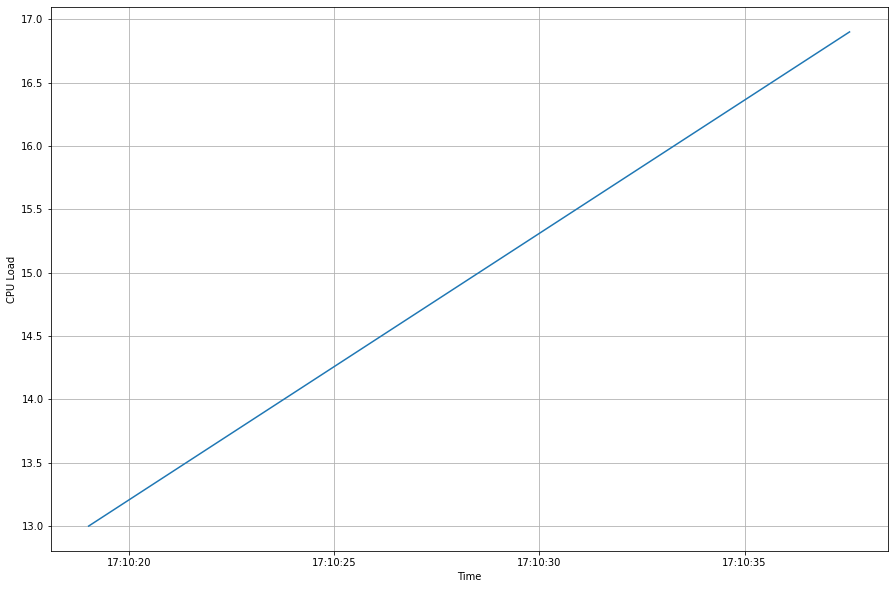

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

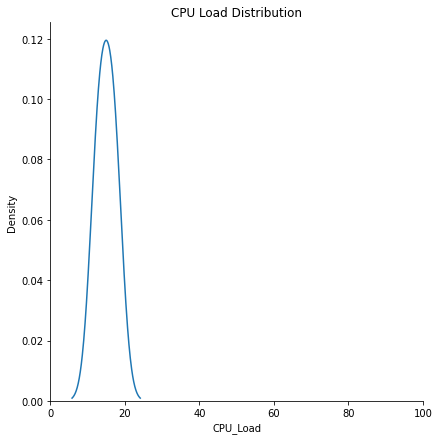

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

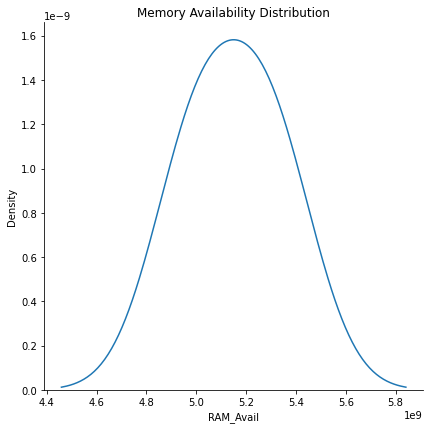

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-13 17:10:22.253428,2651458500,1.0,1.0,1.0,"[0.9082491582491582, 0.9106326219512195, 0.923...",8,0,0,8,"[(909.0, 330.0, 975.0, 420.0), (717.0, 229.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-13 17:10:27.534428,5275407400,1.0,1.0,1.0,[0.8413917758698599],1,0,0,1,"[(555.0, 1231.0, 695.0, 1329.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,2.000000e+00,2.0,2.0,2.0,2.000000,2.0,2.0,2.000000
mean,3.963433e+09,1.0,1.0,1.0,4.500000,0.0,0.0,4.500000
std,1.855412e+09,0.0,0.0,0.0,4.949747,0.0,0.0,4.949747
min,2.651458e+09,1.0,1.0,1.0,1.000000,0.0,0.0,1.000000
25%,3.307446e+09,1.0,1.0,1.0,2.750000,0.0,0.0,2.750000
50%,3.963433e+09,1.0,1.0,1.0,4.500000,0.0,0.0,4.500000
75%,4.619420e+09,1.0,1.0,1.0,6.250000,0.0,0.0,6.250000
max,5.275407e+09,1.0,1.0,1.0,8.000000,0.0,0.0,8.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count       2.000000
mean     3963.435000
std      1855.412838
min      2651.460000
25%      3307.447500
50%      3963.435000
75%      4619.422500
max      5275.410000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1329.38650,True,True,True,1.0,0.111111,1.0,0.111111,1.0,0.111111
1,475.50540,True,True,True,1.0,0.222222,1.0,0.222222,1.0,0.222222
2,420.30722,True,True,True,1.0,0.333333,1.0,0.333333,1.0,0.333333
3,411.08524,True,True,True,1.0,0.444444,1.0,0.444444,1.0,0.444444
4,311.42374,True,True,True,1.0,0.555556,1.0,0.555556,1.0,0.555556
5,290.56403,True,True,True,1.0,0.666667,1.0,0.666667,1.0,0.666667
6,245.58755,True,True,True,1.0,0.777778,1.0,0.777778,1.0,0.777778
7,242.27230,True,True,True,1.0,0.888889,1.0,0.888889,1.0,0.888889
8,113.90194,True,True,True,1.0,1.000000,1.0,1.000000,1.0,1.000000


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1329.38650,True,True,True,1.0,0.111111,1.0,0.111111,1.0,0.111111
1,475.50540,True,True,True,1.0,0.222222,1.0,0.222222,1.0,0.222222
2,420.30722,True,True,True,1.0,0.333333,1.0,0.333333,1.0,0.333333
3,411.08524,True,True,True,1.0,0.444444,1.0,0.444444,1.0,0.444444
4,311.42374,True,True,True,1.0,0.555556,1.0,0.555556,1.0,0.555556
5,290.56403,True,True,True,1.0,0.666667,1.0,0.666667,1.0,0.666667
6,245.58755,True,True,True,1.0,0.777778,1.0,0.777778,1.0,0.777778
7,242.27230,True,True,True,1.0,0.888889,1.0,0.888889,1.0,0.888889
8,113.90194,True,True,True,1.0,1.000000,1.0,1.000000,1.0,1.000000


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

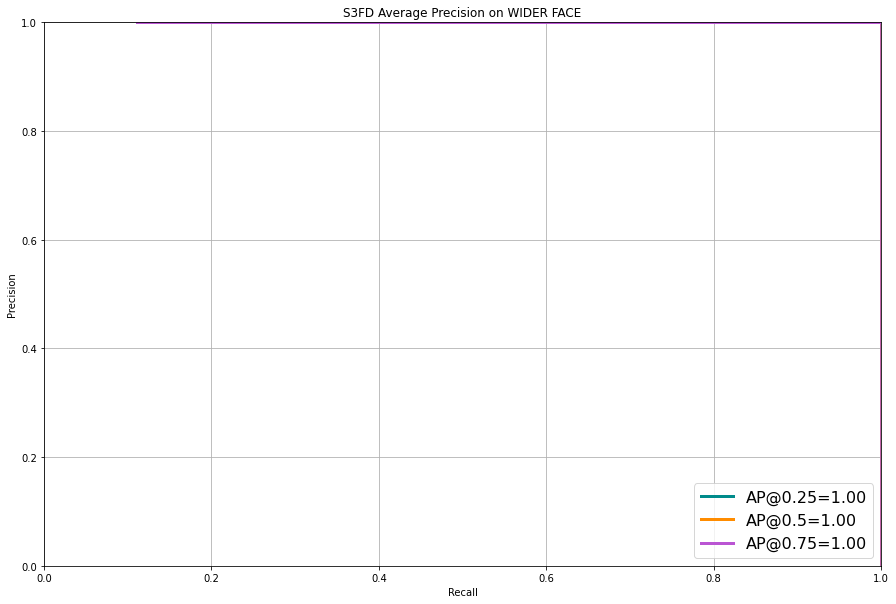

In [19]:
plot_pr(df_ap, 'S3FD Average Precision on WIDER FACE')

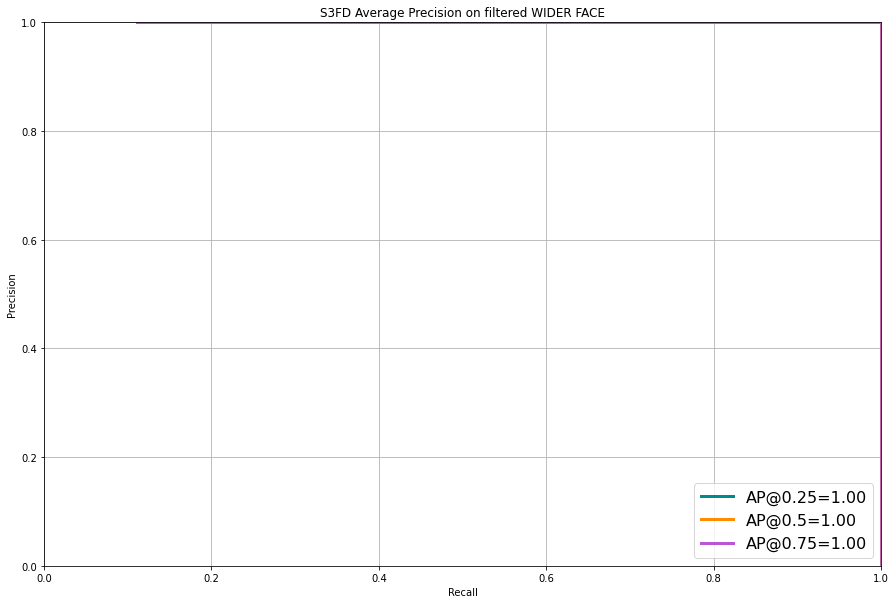

In [20]:
plot_pr(df_ap_filtered, 'S3FD Average Precision on filtered WIDER FACE')

# S3FD Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class S3fdDetector(Detector):
    def __init__(self):
        self.detector = FaceDetectionEngine(weights_path="./models/s3fd/s3fd_convert.pth")
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
    def detect(self, image):
        preds, scores = self.detector.predict(image, dilate_bbox=False)

        return preds, scores

s3fd = S3fdDetector()

Running on device: cpu


In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=s3fd,
    results_folder="s3fd",
    save_videos=True
)

Frames: [====================] 100% [37/37], Videos: [2/2]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.69
Mean detection percentage of faces in all videos: 100.00
Mean confidence of boxes in all videos: 415.42
Mean inference time for all frames: 1746.64ms
